# Change Detection

In [1]:
import geoai
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from pathlib import Path
from geoai.change_detection import ChangeDetection
import geopandas as gpd
from IPython.display import Image

from libs.sentinel import get_sentinel_image_thumbnail
from libs.ee import initialize_ee
ee = initialize_ee(get_ipython())

from libs.s2cloudless import S2Cloudless

In [2]:
directory = 'data/NZ_landslide_inventory/'
auckland_filepath = f'{directory}/cleaned_auckland.gpkg'
gdf = gpd.read_file(auckland_filepath, layer='landslides')
gdf = gdf[gdf['dateoccurence'].notnull()]
gdf

,GlobalID,latitude,longitude,region,dateoccurence,closestdate,geometry
0,cb20f8d7-abeb-4ce5-bafa-a75c01b03136,-36.931306,174.701880,Auckland Region,2023-02-13 23:00:00,2023-02-13 23:00:00,POINT (174.70188 -36.93131)
1,9da581bc-ff20-454f-b6fb-721279cd347a,-36.924269,174.705747,Auckland Region,2023-01-30 23:00:00,2023-01-30 23:00:00,POINT (174.70575 -36.92427)
2,2a361da4-7adf-4f4d-b94c-f3cf9ccccc46,-36.867368,174.738318,Auckland Region,2023-01-31 23:00:00,2023-01-31 23:00:00,POINT (174.73832 -36.86737)
3,4470b30b-6c80-46be-b0f7-e4ec0a5d72fd,-36.861593,174.655298,Auckland Region,2023-02-13 23:00:00,2023-02-13 23:00:00,POINT (174.6553 -36.86159)
4,cfcff56a-7cc6-41f5-9e7e-8da0daa5dbde,-36.817738,174.728127,Auckland Region,2023-01-31 23:00:00,2023-01-31 23:00:00,POINT (174.72813 -36.81774)
...,...,...,...,...,...,...,...
11911,8ac9ffa6-d365-4cb0-bc15-e54c10a63d8b,-36.807419,174.690856,Auckland Region,2023-01-26 11:00:00,2023-01-26 11:00:00,POINT (174.69086 -36.80742)
11912,2801a385-dc6a-44b3-9355-64140b2f1929,-37.133864,174.706530,Auckland Region,2023-01-26 11:00:00,2023-01-26 11:00:00,POINT (174.70653 -37.13386)
11913,c8cc9f20-efac-41b4-bf62-55a625a2ab6e,-36.938192,174.629223,Auckland Region,2023-01-26 11:00:00,2023-01-26 11:00:00,POINT (174.62922 -36.93819)
11914,fa946895-4967-4a14-9b59-48dd0898766e,-36.944683,174.663084,Auckland Region,2023-01-27 11:00:00,2023-01-27 08:00:00,POINT (174.66308 -36.94468)


GlobalID               4760d800-3db6-494b-923f-84f1353cc6c3
latitude                                          -36.95099
longitude                                        174.582021
region                                      Auckland Region
dateoccurence                           2023-01-29 00:00:00
closestdate                             2023-01-29 00:00:00
geometry         POINT (174.582021363252 -36.9509901510936)
Name: 7986, dtype: object

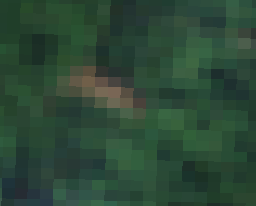

In [ ]:
auckland_dir = './data/2-data-explore-events'

event = gdf.loc[7986]

landslide_img = f'{auckland_dir}/images/7968_174.575889109309_-36.9510233656217_2023-01-29_2023-02-19.png'

display(event)
display(Image(filename=landslide_img))

## Find before landslide images

In [ ]:
start_date = (
        event['dateoccurence'].date() - pd.Timedelta(days=60)
    ).strftime("%Y-%m-%d")
end_date = event['dateoccurence'].date().strftime("%Y-%m-%d")

start_date, end_date

In [ ]:
s2cloudless = S2Cloudless(ee)

point = event['geometry']
# Extract coordinates from Shapely Point
lon = point.x
lat = point.y

# Create Earth Engine Point geometry
aoi = ee.Geometry.Point([lon, lat]).buffer(1000)

# start_date
# end_date,
buffer=50
cloud_filter=30

m_cloud_free = s2cloudless.cloud_free_map(aoi, start_date, end_date, buffer=buffer, cloud_filter=cloud_filter)
m_cloud_free.addLayer(ee.Geometry.Point([lon, lat]), {'color': 'red'}, 'My Pinpoint')
m_cloud_free

## Export all `tif` file

'Filename ./data/4_change_detection/images/0_174.701880487593_-36.931306466746_2022-12-15_2023-02-07.tif'

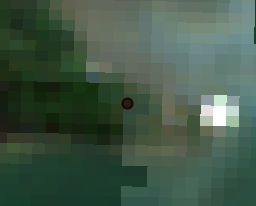

'Filename ./data/4_change_detection/images/1_174.70574721288_-36.9242685339089_2022-12-01_2023-01-24.tif'

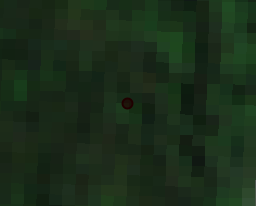

In [ ]:
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}
out_dir = './data/4_change_detection/'
start_date_offset = 60
end_date_offset = 6 # s2 revisit time is 5 days, make sure we have images before the event
buffer=50
cloud_filter=30
s2cloudless=S2Cloudless(ee)

for idx, event in gdf.iterrows():
    filename, filepath_with_marker = get_sentinel_image_thumbnail(
        ee,
        s2cloudless,
        event,
        idx,
        out_dir,
        start_date_offset=start_date_offset,
        end_date_offset=end_date_offset,
        buffer=buffer,
        cloud_filter=cloud_filter,
    )
    
    display(f"Filename {filename}")
    display(Image(filename=filepath_with_marker))